# SVZ cell cell type-specific statistical test (accounting for group structure)

## Outline

The **MLAging - SVZ cell type** workflow consists of sections:

`30 SVZpreprocessing.R` Data preprocessing and preparation in Seurat.

`41 SVZ Cell Type ELN Tuning` ELN model tunning using *non-binarized* and *binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`42 SVZ Cell Type ELN 10x` Run the best ELN model for both binarized and nonbinarized HVGs over 10 random seeds.

`43 SVZ Cell Type ELN Result Viz` Result visulization.

`44 SVZ Cell Type Stat` Stat test on whether exercise rejuvenates cells **this notebook**:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *
import statsmodels.formula.api as smf

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf

In [2]:
input_train="/users/dyu20/data/cell2location/MLAging/data/svz_processed/svz_ctl_train_cell_sep3integ_batch1.csv" 
input_test="/users/dyu20/data/cell2location/MLAging/data/svz_processed/svz_ctl_test_cell_sep3integ_batch2.csv"
input_test_34="/users/dyu20/data/cell2location/MLAging/data/svz_processed/svz_ex_test_34_cell_sep3integ_batch2.csv" 
input_test_68="/users/dyu20/data/cell2location/MLAging/data/svz_processed/svz_ex_test_68_cell_sep3integ_batch2.csv"

In [3]:
df_train = pd.read_csv(input_train, index_col=0)
df_test = pd.read_csv(input_test, index_col=0)
df_test_34 = pd.read_csv(input_test_34, index_col=0)
df_test_68 = pd.read_csv(input_test_68, index_col=0)

In [4]:
cell_types = ['Microglia', 'Astrocyte_qNSC', 'Endothelial', 'Neuroblast', 
              'Oligodendro', 'aNSC_NPC', 'Mural']
for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [5]:
baseline_df = []
for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    baseline_df.append(max(y_test.value_counts())/len(y_test))
    file.close()

In [6]:
cell_types = ['Microglia', 'Astrocyte_qNSC', 'Endothelial', 'Neuroblast', 
              'Oligodendro', 'aNSC_NPC', 'Mural']

In [7]:
for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    locals()[i] = all_10_files[0]
    file.close()

In [8]:
def violin_df(animal_list, data_df, model):
    df_vol = pd.DataFrame(columns=['animal', 'target', 'major_group', 'pred_prob'])
    for i in animal_list:
        print(i)
        idx = data_df.loc[data_df['animal'] == i,].index
        sub_df = data_df.loc[idx]
        df_new = sub_df.loc[:,['animal', 'target', 'major_group']]
    
        train_Xi = sub_df.iloc[:,:-3]
        train_Xi = binarize_data(train_Xi)
            
        test_y_pred = pd.DataFrame(model.predict_proba(train_Xi)[:,1], columns=['pred_prob'])
        test_y_pred.index = idx
        df_new['pred_prob'] = test_y_pred
        df_vol = pd.concat([df_vol, df_new])
    df_vol['pred_prob'] =  df_vol['pred_prob'].astype(float)
    return df_vol

In [11]:
train_control_list = [ "Y5", "Y7", "O5","O7"]
test_ex_34_list = ['Y3', 'Y4', 'O3', 'O4', ]
test_ex_68_list = ['Y6', 'Y8', 'O6', 'O8']
test_control_list = ["Y1", "Y2", "O2"]

results = {}
for i in cell_types:
    print(i)
    train_vol = violin_df(train_control_list, df_train[df_train['major_group'] == i], locals()[i])
    test_ex_34_vol = violin_df(test_ex_34_list, df_test_34[df_test_34['major_group'] == i], locals()[i])
    test_ex_68_vol = violin_df(test_ex_68_list, df_test_68[df_test_68['major_group'] == i], locals()[i])
    test_vol = violin_df(test_control_list, df_test[df_test['major_group'] == i], locals()[i])

    test_vol["AgeCond"] = "Young Control"
    test_vol.loc[test_vol.target == 1,'AgeCond'] = "Aged Control"
    
    test_ex_34_vol["AgeCond"] = "Young Exercise"
    test_ex_34_vol.loc[test_ex_34_vol.target == 1,'AgeCond'] = "Aged Exercise"
    
    test_ex_68_vol["AgeCond"] = "Young Exercise"
    test_ex_68_vol.loc[test_ex_68_vol.target == 1,'AgeCond'] = "Aged Exercise"
    
    test_vol_all = pd.concat([test_vol, test_ex_34_vol, test_ex_68_vol])
    test_ex_vol = pd.concat([test_ex_34_vol, test_ex_68_vol])
    
    test_vol_young = test_vol_all.loc[test_vol_all.target==0,:]
    test_vol_young["exercise"] = "Y"
    test_vol_young.loc[test_vol_young.AgeCond == "Young Control",'exercise'] = "N"
    model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_young, groups=test_vol_young['animal'])
    result_young_ex = model.fit()

    test_vol_aged = test_vol_all.loc[test_vol_all.target==1,:]
    test_vol_aged["exercise"] = "Y"
    test_vol_aged.loc[test_vol_aged.AgeCond == "Aged Control",'exercise'] = "N"
    model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_aged, groups=test_vol_aged['animal'])
    result_aged_ex = model.fit()

    
    # Save the results in the dictionary
    results[i] = {
        "train_vol": train_vol,
        "test_ex_vol": test_ex_vol,
        "test_vol": test_vol,
        "test_vol_all": test_vol_all,
        "result_young_ex": result_young_ex,
        "result_aged_ex": result_aged_ex
    }

Microglia
Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Astrocyte_qNSC
Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2
Endothelial
Y5


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Neuroblast
Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2
Oligodendro
Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


aNSC_NPC
Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2
Mural
Y5
Y7
O5
O7


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2


/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
residuals = results[cell_types[3]]["result_young_ex"].resid

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
sm.qqplot(residuals, line='s')
plt.show()

In [11]:
print(cell_types[3])
results[cell_types[3]]["result_young_ex"].summary()

Neuroblast


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:             MixedLM Dependent Variable: pred_prob
No. Observations:  6021    Method:             REML     
No. Groups:        6       Scale:              0.0147   
Min. group size:   248     Log-Likelihood:     4144.2108
Max. group size:   1623    Converged:          Yes      
Mean group size:   1003.5                               
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.347    0.071  4.857 0.000  0.207  0.486
exercise[T.Y] -0.193    0.087 -2.215 0.027 -0.365 -0.022
Group Var      0.010    0.059                           
========================================================

"""

In [81]:
results['Neuroblast']["result_aged_ex"].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:             MixedLM Dependent Variable: pred_prob
No. Observations:  2338    Method:             REML     
No. Groups:        5       Scale:              0.0295   
Min. group size:   74      Log-Likelihood:     784.6588 
Max. group size:   952     Converged:          Yes      
Mean group size:   467.6                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.853    0.238  3.578 0.000  0.386  1.320
exercise[T.Y] -0.179    0.266 -0.671 0.502 -0.701  0.343
Group Var      0.057    0.269                           
========================================================

"""

In [12]:
print(cell_types[5])
results[cell_types[5]]["result_young_ex"].summary()

aNSC_NPC


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:             MixedLM Dependent Variable: pred_prob
No. Observations:  3432    Method:             REML     
No. Groups:        6       Scale:              0.0116   
Min. group size:   154     Log-Likelihood:     2764.0579
Max. group size:   995     Converged:          Yes      
Mean group size:   572.0                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.206    0.044  4.720 0.000  0.120  0.291
exercise[T.Y] -0.115    0.053 -2.154 0.031 -0.219 -0.010
Group Var      0.004    0.025                           
========================================================

"""

In [78]:
cell = cell_types[5]
print(cell)
results[cell]["result_aged_ex"].summary()

Mural


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:             MixedLM Dependent Variable: pred_prob
No. Observations:  1130    Method:             REML     
No. Groups:        5       Scale:              0.0142   
Min. group size:   129     Log-Likelihood:     783.9164 
Max. group size:   286     Converged:          Yes      
Mean group size:   226.0                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.927    0.095  9.788 0.000  0.741  1.112
exercise[T.Y] -0.048    0.106 -0.453 0.651 -0.255  0.160
Group Var      0.009    0.062                           
========================================================

"""

In [40]:
cell_types = ['Microglia',
 'Astrocyte_qNSC',
 'Endothelial',
 'Oligodendro',
 'aNSC_NPC',
 'Mural']

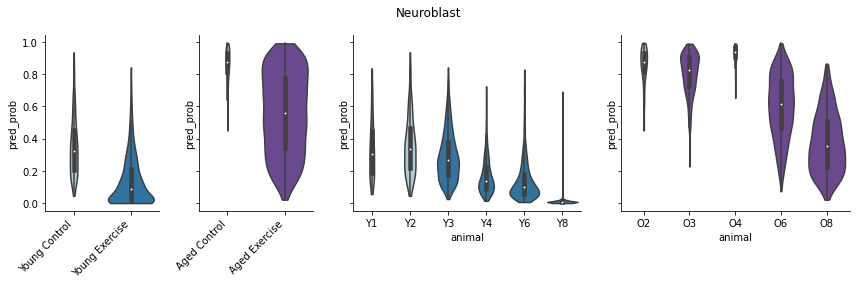

In [62]:
import matplotlib.gridspec as gridspec

# create a figure with three subplots in a row, with the width ratio of 1:1:2
for cell_type in ['Neuroblast']:
    test_vol_all = results[cell_type]['test_vol_all']
   # create a figure with three subplots in a row
    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 2, 2]}, sharey=True)
    
    # plot first violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Young Control", "Young Exercise"])]
    sns.violinplot(x=df.AgeCond, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[0]]*1 + [sns.color_palette("Paired")[1]]*1,
               ax=axs[0])

    axs[0].set_xticklabels(["Young Control", "Young Exercise"],
        rotation=45,
        horizontalalignment='right')
    axs[0].set_xlabel("")
    sns.despine(ax=axs[0])

    # plot second violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Aged Control", "Aged Exercise"])]
    sns.violinplot(x=df.AgeCond, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*1,
               ax=axs[1])

    axs[1].set_xticklabels(["Aged Control", "Aged Exercise"],
        rotation=45,
        horizontalalignment='right')
    axs[1].set_xlabel("")
    sns.despine(ax=axs[1])

    # plot third violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Young Control", "Young Exercise"])]
    sns.violinplot(x=df.animal, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               palette=[sns.color_palette("Paired")[0]]*2 + [sns.color_palette("Paired")[1]]*4,
               ax=axs[2])


    # plot fourth violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Aged Control", "Aged Exercise"])]
    sns.violinplot(x=df.animal, y=df.pred_prob, data=df, cut=0,
               scale='count',
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*4,
               ax=axs[3])

    
    sns.despine()
    plt.suptitle(cell_type)
    plt.tight_layout()
    plt.savefig('../figures/5e_11_violin_neuroblast.pdf')
    plt.show()


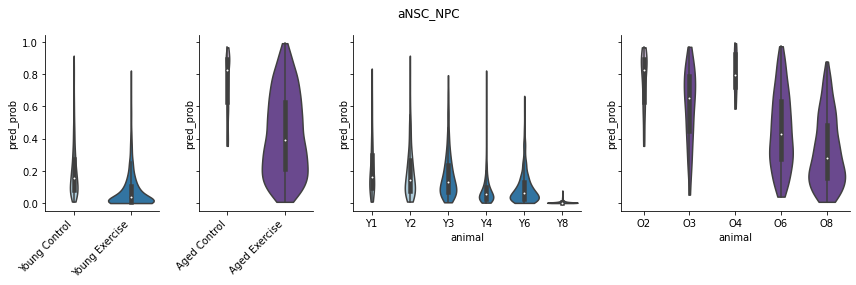

In [82]:
import matplotlib.gridspec as gridspec

# create a figure with three subplots in a row, with the width ratio of 1:1:2
for cell_type in ['aNSC_NPC']:
    test_vol_all = results[cell_type]['test_vol_all']
   # create a figure with three subplots in a row
    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 2, 2]}, sharey=True)
    
    # plot first violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Young Control", "Young Exercise"])]
    sns.violinplot(x=df.AgeCond, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[0]]*1 + [sns.color_palette("Paired")[1]]*1,
               ax=axs[0])

    axs[0].set_xticklabels(["Young Control", "Young Exercise"],
        rotation=45,
        horizontalalignment='right')
    axs[0].set_xlabel("")
    sns.despine(ax=axs[0])

    # plot second violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Aged Control", "Aged Exercise"])]
    sns.violinplot(x=df.AgeCond, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*1,
               ax=axs[1])

    axs[1].set_xticklabels(["Aged Control", "Aged Exercise"],
        rotation=45,
        horizontalalignment='right')
    axs[1].set_xlabel("")
    sns.despine(ax=axs[1])

    # plot third violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Young Control", "Young Exercise"])]
    sns.violinplot(x=df.animal, y=df.pred_prob, data=df, cut=0,
               scale='count', 
               palette=[sns.color_palette("Paired")[0]]*2 + [sns.color_palette("Paired")[1]]*4,
               ax=axs[2])


    # plot fourth violin plot
    df = test_vol_all[test_vol_all.AgeCond.isin(["Aged Control", "Aged Exercise"])]
    sns.violinplot(x=df.animal, y=df.pred_prob, data=df, cut=0,
               scale='count',
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*4,
               ax=axs[3])

    
    sns.despine()
    plt.suptitle(cell_type)
    plt.tight_layout()
    plt.savefig('../figures/5e2_11_violin_neuroblast.pdf')
    plt.show()


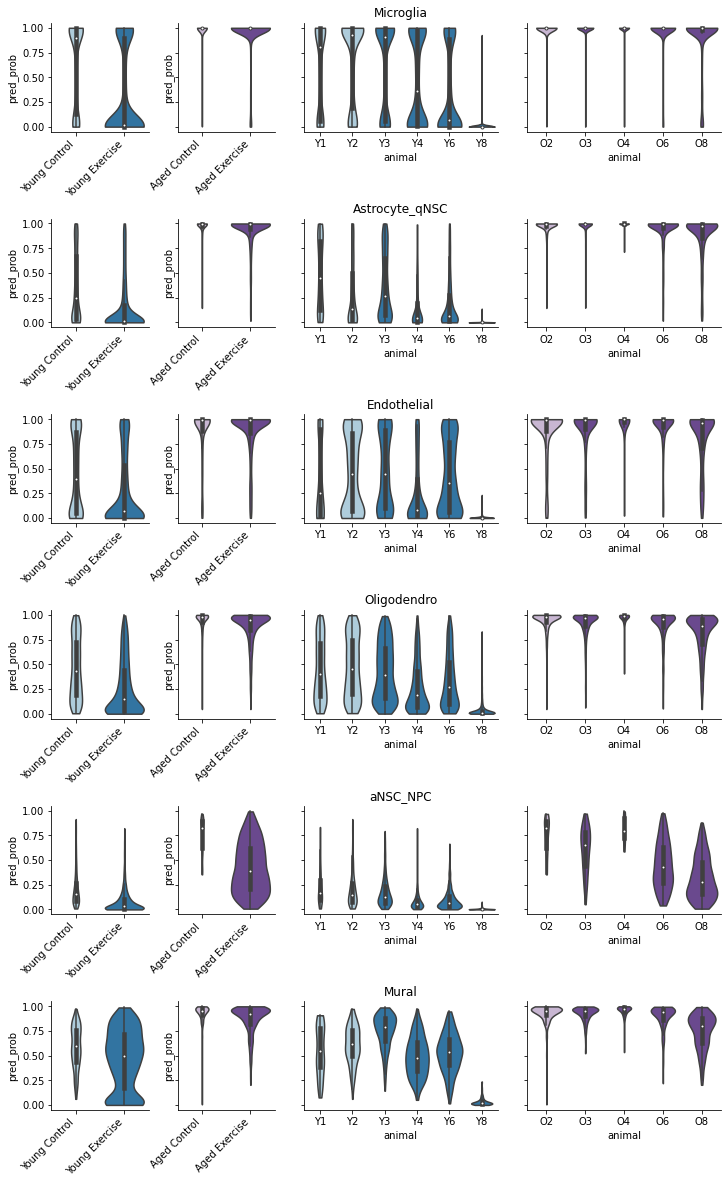

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

fig, axs = plt.subplots(6, 4, figsize=(12, 20), gridspec_kw={'width_ratios': [1, 1, 2, 2], 'hspace': 0.8}, sharey=True)

# flatten the array of subplots into a 1D array
axs = axs.flatten()
scale="count"
for i, cell_type in enumerate(cell_types):
    test_vol_all = results[cell_type]['test_vol_all']
    df_young = test_vol_all[test_vol_all.AgeCond.isin(["Young Control", "Young Exercise"])]
    df_aged = test_vol_all[test_vol_all.AgeCond.isin(["Aged Control", "Aged Exercise"])]

    # plot first violin plot
    sns.violinplot(x=df_young.AgeCond, y=df_young.pred_prob, data=df_young, cut=0,
                   scale=scale, bw=0.25, palette=[sns.color_palette("Paired")[0]]*1 + [sns.color_palette("Paired")[1]]*1,
                   ax=axs[i*4])

    axs[i*4].set_xticklabels(["Young Control", "Young Exercise"], rotation=45, horizontalalignment='right')
    axs[i*4].set_xlabel("")

    sns.despine(ax=axs[i*4])

    # plot second violin plot
    sns.violinplot(x=df_aged.AgeCond, y=df_aged.pred_prob, data=df_aged, cut=0,
                   scale=scale, bw=0.25, palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*1,
                   ax=axs[i*4+1])

    axs[i*4+1].set_xticklabels(["Aged Control", "Aged Exercise"], rotation=45, horizontalalignment='right')
    axs[i*4+1].set_xlabel("")
    sns.despine(ax=axs[i*4+1])

    # plot third violin plot
    sns.violinplot(x=df_young.animal, y=df_young.pred_prob, data=df_young, cut=0,
                   scale=scale, palette=[sns.color_palette("Paired")[0]]*2 + [sns.color_palette("Paired")[1]]*4,
                   ax=axs[i*4+2])

    # plot fourth violin plot
    sns.violinplot(x=df_aged.animal, y=df_aged.pred_prob, data=df_aged, cut=0,
                   scale=scale, palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*4,
                   ax=axs[i*4+3])

    axs[i*4+2].set_ylabel("")
    axs[i*4+2].set_title(cell_type)

    axs[i*4+3].set_ylabel("")
    sns.despine(ax=axs[i*4+2])
    sns.despine(ax=axs[i*4+3])

plt.tight_layout()
plt.savefig('../figures/S8e_11_violin_6cells.pdf')
plt.show()
